## 1️⃣ Configuración Inicial

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)
pd.set_option("display.max_columns", None)

print("✅ Configuración completada")

✅ Configuración completada


## 2️⃣ Cargar Datos

In [2]:
# CI compatibility: ensure engine uses sqlite when TEST_DB_PATH is provided
import os

if os.getenv("CI_TEST") == "true":
    sqlite_path = os.getenv("TEST_DB_PATH")
    if sqlite_path:
        from sqlalchemy import create_engine

        engine = create_engine(f"sqlite:///{sqlite_path}")

In [3]:
from sqlalchemy import create_engine
import urllib.parse
from utils.config import DB_CONNECTION_STRING

if "engine" not in globals():
    quoted_conn_str = urllib.parse.quote_plus(DB_CONNECTION_STRING)
    engine = create_engine(f"mssql+pyodbc:///?odbc_connect={quoted_conn_str}")

# Cargar datos necesarios - YA VIENEN NORMALIZADOS DESDE SQL
df_ipc_sectorial = pd.read_sql("SELECT * FROM INE_IPC_Sectorial_ECOICOP", engine)
df_gasto = pd.read_sql("SELECT * FROM INE_Gasto_Medio_Hogar_Quintil", engine)
df_ipc_nacional = pd.read_sql("SELECT * FROM INE_IPC_Nacional", engine)

# Cargar resultados del notebook anterior
output_dir = project_root / "outputs"
df_gini_s80s20 = pd.read_parquet(output_dir / "gini_s80s20_nacional.parquet")
df_pivot_deciles = pd.read_parquet(output_dir / "renta_real_deciles.parquet")
df_analisis_conjunto = pd.read_parquet(
    output_dir / "umbral_pobreza_nominal_real.parquet"
)

# Recargar AROPE
df_arope_edad = pd.read_sql("SELECT * FROM INE_AROPE_Edad_Sexo", engine)
df_arope_anual = (
    df_arope_edad[
        (df_arope_edad["Sexo"] == "Total")
        & (df_arope_edad["Edad"] == "Total")
        & (df_arope_edad["Indicador"] == "AROPE")
    ]
    .groupby("Anio")["Valor"]
    .mean()
    .reset_index()
)
df_arope_anual.columns = ["Anio", "AROPE_%"]

print("✅ Datos cargados (normalizados desde SQL)")

✅ Datos cargados (normalizados desde SQL)


## 3️⃣ Inflación Diferencial por Quintil

### 3.1 Mapeo de categorías EPF → ECOICOP

In [4]:
# Mapeo categorías
mapeo_categorias = {
    "Alimentos_y_bebidas_no_alcohólicas.": "Alimentos y bebidas no alcohólicas",
    "Bebidas_alcohólicas_y_tabaco.": "Bebidas alcohólicas y tabaco",
    "Vestido_y_calzado.": "Vestido y calzado",
    "Vivienda,_agua,_electricidad,_gas_y_otros_combustibles.": "Vivienda, agua, electricidad, gas y otros combustibles",
    "Muebles,_artículos_del_hogar_y_artículos_para_el_mantenimiento_corriente_del_hogar.": "Muebles, artículos del hogar y artículos para el mantenimiento corriente del hogar",
    "Sanidad.": "Sanidad",
    "Transporte.": "Transporte",
    "Comunicaciones.": "Comunicaciones",
    "Ocio_y_cultura.": "Ocio y cultura",
    "Enseñanza.": "Enseñanza",
    "Restaurantes_y_hoteles.": "Restaurantes y hoteles",
    "Otros_bienes_y_servicios.": "Otros bienes y servicios",
}

# Preparar EPF
df_gasto_clean = df_gasto[
    (df_gasto["Quintil"] != "Total") & (df_gasto["Tipo_Valor"] == "Gasto_Hogar")
].copy()
df_gasto_clean["Categoria_ECOICOP"] = df_gasto_clean["Grupo_Gasto"].map(
    mapeo_categorias
)
df_gasto_clean = df_gasto_clean[df_gasto_clean["Categoria_ECOICOP"].notna()]

# Preparar IPC sectorial
df_ipc_temp = df_ipc_sectorial.copy()

# Normalizar nombres columnas (trim)
col_map = {c: c.strip() for c in df_ipc_temp.columns}
df_ipc_temp = df_ipc_temp.rename(columns=col_map)

# Buscar columna que contiene 'tipo' o 'metrica' (case-insensitive)
metric_col_candidates = [
    c
    for c in df_ipc_temp.columns
    if "tipo" in c.lower() or "metrica" in c.lower() or "tipo_metr" in c.lower()
]
metric_col = None
if "Tipo_Metrica" in df_ipc_temp.columns:
    metric_col = "Tipo_Metrica"
elif len(metric_col_candidates) > 0:
    metric_col = metric_col_candidates[0]

# Aplicar filtro 'Variación anual' si existe la columna
if metric_col and metric_col in df_ipc_temp.columns:
    df_ipc_clean = df_ipc_temp[
        df_ipc_temp[metric_col].astype(str) == "Variación anual"
    ].copy()
    if df_ipc_clean.empty:
        print(
            "⚠️ No hay filas con Variación anual. Usando todos los datos de IPC_Indice"
        )
        df_ipc_clean = df_ipc_temp[df_ipc_temp["IPC_Indice"].notna()].copy()
else:
    print(
        "⚠️ No se encontró columna Tipo_Metrica; usando valores numéricos de IPC_Indice"
    )
    df_ipc_clean = df_ipc_temp[df_ipc_temp["IPC_Indice"].notna()].copy()

# Normalizar valor de IPC a número (coma -> punto)
if "IPC_Indice" in df_ipc_clean.columns:
    df_ipc_clean["Inflacion_%"] = pd.to_numeric(
        df_ipc_clean["IPC_Indice"].astype(str).str.replace(",", "."), errors="coerce"
    )
else:
    df_ipc_clean["Inflacion_%"] = pd.Series(dtype=float)

# 🔧 FIX CRÍTICO: Eliminar prefijo "Total Nacional. " de las categorías IPC
df_ipc_clean["Categoria_ECOICOP"] = df_ipc_clean["Categoria_ECOICOP"].str.replace(
    "Total Nacional. ", "", regex=False
)

# Excluir "Índice general" (no es una categoría de gasto específica)
df_ipc_clean = df_ipc_clean[df_ipc_clean["Categoria_ECOICOP"] != "Índice general"]

print(f"✅ Datos preparados para cálculo de IPC ponderado")
print(
    f"   • EPF: {len(df_gasto_clean)} filas, {df_gasto_clean['Categoria_ECOICOP'].nunique()} categorías"
)
print(
    f"   • IPC: {len(df_ipc_clean)} filas, {df_ipc_clean['Categoria_ECOICOP'].nunique()} categorías"
)
print(
    f"   • Categorías comunes: {len(set(df_gasto_clean['Categoria_ECOICOP'].unique()) & set(df_ipc_clean['Categoria_ECOICOP'].unique()))}"
)

✅ Datos preparados para cálculo de IPC ponderado
   • EPF: 1080 filas, 12 categorías
   • IPC: 288 filas, 12 categorías
   • Categorías comunes: 12


### 3.2 Cálculo de IPC ponderado por quintil

In [5]:
# Calcular IPC ponderado por quintil y año
print("🔍 DIAGNÓSTICO DE DATOS:")
print(f"   • df_gasto_clean tiene {len(df_gasto_clean)} filas")
print(f"   • df_ipc_clean tiene {len(df_ipc_clean)} filas")
print(
    f"   • Años en df_gasto_clean: {sorted(df_gasto_clean['Anio'].unique()) if len(df_gasto_clean) > 0 else 'VACÍO'}"
)
print(
    f"   • Años en df_ipc_clean: {sorted(df_ipc_clean['Anio'].unique()) if len(df_ipc_clean) > 0 else 'VACÍO'}"
)

if len(df_gasto_clean) > 0:
    print(f"\n📋 Muestra df_gasto_clean (primeras 3 filas):")
    print(df_gasto_clean[["Anio", "Quintil", "Categoria_ECOICOP", "Valor"]].head(3))
    print(
        f"\n   Categorías únicas en df_gasto_clean: {df_gasto_clean['Categoria_ECOICOP'].nunique()}"
    )
    print(f"   Muestra: {list(df_gasto_clean['Categoria_ECOICOP'].unique())[:3]}")

if len(df_ipc_clean) > 0:
    print(f"\n📋 Muestra df_ipc_clean (primeras 3 filas):")
    print(df_ipc_clean[["Anio", "Categoria_ECOICOP", "Inflacion_%"]].head(3))
    print(
        f"\n   Categorías únicas en df_ipc_clean: {df_ipc_clean['Categoria_ECOICOP'].nunique()}"
    )
    print(f"   Muestra: {list(df_ipc_clean['Categoria_ECOICOP'].unique())[:3]}")
else:
    print("\n⚠️ df_ipc_clean está VACÍO - revisar filtrado en celda anterior")

resultados = []

for ano in sorted(df_gasto_clean["Anio"].unique()):
    df_gasto_ano = df_gasto_clean[df_gasto_clean["Anio"] == ano]
    df_ipc_ano = df_ipc_clean[df_ipc_clean["Anio"] == ano]

    print(
        f"\n🔎 Año {ano}: gasto={len(df_gasto_ano)} filas, ipc={len(df_ipc_ano)} filas"
    )

    if not df_gasto_ano.empty and not df_ipc_ano.empty:
        df_merged = df_gasto_ano.merge(
            df_ipc_ano[["Categoria_ECOICOP", "Inflacion_%"]],
            on="Categoria_ECOICOP",
            how="inner",
        )

        print(f"   → Merge: {len(df_merged)} filas")

        if len(df_merged) == 0:
            print(f"   ⚠️ MERGE VACÍO - categorías no coinciden:")
            cat_gasto = set(df_gasto_ano["Categoria_ECOICOP"].unique())
            cat_ipc = set(df_ipc_ano["Categoria_ECOICOP"].unique())
            print(f"      En gasto pero NO en IPC: {cat_gasto - cat_ipc}")
            print(f"      En IPC pero NO en gasto: {cat_ipc - cat_gasto}")

        for quintil in df_merged["Quintil"].unique():
            df_q = df_merged[df_merged["Quintil"] == quintil].copy()
            gasto_total = df_q["Valor"].sum()

            if gasto_total > 0:
                df_q["Pct_Gasto"] = df_q["Valor"] / gasto_total
                df_q["Contrib"] = df_q["Pct_Gasto"] * pd.to_numeric(
                    df_q["Inflacion_%"], errors="coerce"
                )
                ipc_ponderado = df_q["Contrib"].sum()

                resultados.append(
                    {"Anio": ano, "Quintil": quintil, "IPC_Ponderado_%": ipc_ponderado}
                )

df_inflacion_diff = pd.DataFrame(resultados)
print(
    f"\n✅ IPC ponderado calculado para {len(df_inflacion_diff)} combinaciones año-quintil"
)

if len(df_inflacion_diff) == 0:
    print("\n🔴 ERROR: No se pudo calcular ningún IPC ponderado")
    print("   Causa probable: df_ipc_clean vacío o sin coincidencias de categorías")
    print("   Revisar filtrado en celda 3.1 (mapeo de categorías)")

🔍 DIAGNÓSTICO DE DATOS:
   • df_gasto_clean tiene 1080 filas
   • df_ipc_clean tiene 288 filas
   • Años en df_gasto_clean: [np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
   • Años en df_ipc_clean: [np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]

📋 Muestra df_gasto_clean (primeras 3 filas):
     Anio Quintil                   Categoria_ECOICOP    Valor
450  2023      Q1  Alimentos y bebidas no alcohólicas  3333.96
451

### 3.3 Análisis de la brecha inflacionaria

In [6]:
if not df_inflacion_diff.empty:
    # Crear pivot
    pivot = df_inflacion_diff.pivot_table(
        index="Anio", columns="Quintil", values="IPC_Ponderado_%"
    )
    if {"Q1", "Q5"}.issubset(pivot.columns):
        pivot["Brecha_Q1_Q5"] = pivot["Q1"] - pivot["Q5"]
    else:
        print("⚠️ Q1 o Q5 no están presentes en pivot; omitiendo  Brecha_Q1_Q5")
        pivot["Brecha_Q1_Q5"] = float("nan")

    print("\n" + "=" * 100)
    print("INFLACIÓN DIFERENCIAL POR QUINTIL (años clave)")
    print("=" * 100)
    # Evitar error si faltan años en el subset
    rows_to_show = [y for y in [2020, 2021, 2022, 2023] if y in pivot.index]
    print(
        pivot.loc[
            rows_to_show,
            [c for c in ["Q1", "Q5", "Brecha_Q1_Q5"] if c in pivot.columns],
        ]
    )

    # Análisis 2022
    if 2022 in pivot.index and not pd.isna(pivot.loc[2022, "Brecha_Q1_Q5"]):
        brecha_2022 = pivot.loc[2022, "Brecha_Q1_Q5"]
        q1_2022 = pivot.loc[2022, "Q1"] if "Q1" in pivot.columns else None
        q5_2022 = pivot.loc[2022, "Q5"] if "Q5" in pivot.columns else None

        print(f"\n💡 AÑO CRÍTICO 2022:")
        if q1_2022 is not None and q5_2022 is not None:
            print(f"   Q1 (pobres): {q1_2022:.2f}%")
            print(f"   Q5 (ricos): {q5_2022:.2f}%")
            print(f"   Brecha: {brecha_2022:+.2f} pp")

            if brecha_2022 > 0:
                print(
                    f"\n   🔴 INFLACIÓN REGRESIVA: Los pobres sufrieron {brecha_2022:.2f} pp MÁS de inflación"
                )
        else:
            print(
                "⚠️ No se dispone de Q1/Q5 para 2022; no se puede calcular brecha detallada"
            )
else:
    print("⚠️ No se pudo calcular inflación diferencial")


INFLACIÓN DIFERENCIAL POR QUINTIL (años clave)
Quintil         Q1        Q5  Brecha_Q1_Q5
Anio                                      
2020     -1.092819 -1.121523      0.028704
2021      5.726255  4.876557      0.849698
2022     10.995601  9.514654      1.480947
2023     -0.818229  0.603593     -1.421822

💡 AÑO CRÍTICO 2022:
   Q1 (pobres): 11.00%
   Q5 (ricos): 9.51%
   Brecha: +1.48 pp

   🔴 INFLACIÓN REGRESIVA: Los pobres sufrieron 1.48 pp MÁS de inflación


### 3.4 Visualización de inflación diferencial

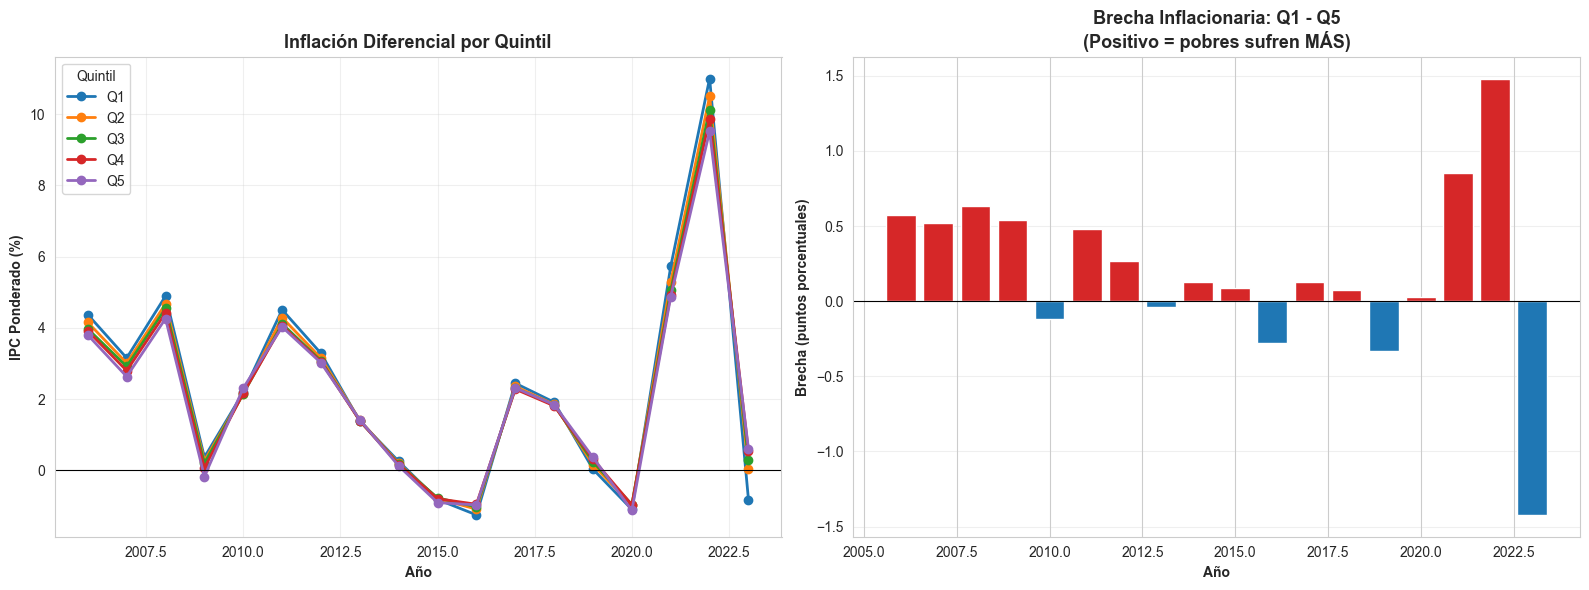

In [7]:
if not df_inflacion_diff.empty and len(pivot) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Panel 1: Evolución IPC por quintil
    for col in ["Q1", "Q2", "Q3", "Q4", "Q5"]:
        if col in pivot.columns:
            axes[0].plot(pivot.index, pivot[col], marker="o", label=col, linewidth=2)
    axes[0].set_xlabel("Año", fontweight="bold")
    axes[0].set_ylabel("IPC Ponderado (%)", fontweight="bold")
    axes[0].set_title(
        "Inflación Diferencial por Quintil", fontweight="bold", fontsize=13
    )
    axes[0].legend(title="Quintil")
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0, color="black", linestyle="-", linewidth=0.8)

    # Panel 2: Brecha Q1 vs Q5
    colors = ["#d62728" if x > 0 else "#1f77b4" for x in pivot["Brecha_Q1_Q5"]]
    axes[1].bar(pivot.index, pivot["Brecha_Q1_Q5"], color=colors)
    axes[1].axhline(y=0, color="black", linestyle="-", linewidth=0.8)
    axes[1].set_xlabel("Año", fontweight="bold")
    axes[1].set_ylabel("Brecha (puntos porcentuales)", fontweight="bold")
    axes[1].set_title(
        "Brecha Inflacionaria: Q1 - Q5\n(Positivo = pobres sufren MÁS)",
        fontweight="bold",
        fontsize=13,
    )
    axes[1].grid(True, alpha=0.3, axis="y")

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Visualización omitida (datos insuficientes)")

## 4️⃣ Análisis Específico COVID: 2019 vs 2023

### 4.1 Preparar datos comparativos

In [8]:
# Extraer valores 2019 y 2023 - Parquets del notebook anterior usan 'Año' con tilde
gini_2019 = df_gini_s80s20[df_gini_s80s20["Año"] == 2019]["Gini"].values[0]
gini_2023 = df_gini_s80s20[df_gini_s80s20["Año"] == 2023]["Gini"].values[0]

arope_2019 = df_arope_anual[df_arope_anual["Anio"] == 2019]["AROPE_%"].values[0]
arope_2023 = df_arope_anual[df_arope_anual["Anio"] == 2023]["AROPE_%"].values[0]

# Deciles (ya vienen como escalares, no necesitan conversión)
d1_2019 = df_pivot_deciles.loc[2019, "D1"]
d1_2023 = df_pivot_deciles.loc[2023, "D1"]
d10_2019 = df_pivot_deciles.loc[2019, "D10"]
d10_2023 = df_pivot_deciles.loc[2023, "D10"]

umbral_2019 = df_analisis_conjunto[df_analisis_conjunto["Año"] == 2019][
    "Umbral_Real_€_Base"
].values[0]
umbral_2023 = df_analisis_conjunto[df_analisis_conjunto["Año"] == 2023][
    "Umbral_Real_€_Base"
].values[0]

# Calcular cambios
cambio_gini_covid = gini_2023 - gini_2019
cambio_arope_covid = arope_2023 - arope_2019
cambio_d1_covid_pct = ((d1_2023 - d1_2019) / d1_2019) * 100
cambio_d10_covid_pct = ((d10_2023 - d10_2019) / d10_2019) * 100
cambio_umbral_covid_pct = ((umbral_2023 - umbral_2019) / umbral_2019) * 100

print("✅ Datos COVID preparados")

✅ Datos COVID preparados


### 4.2 Tabla comparativa Pre-COVID vs Post-COVID

In [9]:
tabla_covid = pd.DataFrame(
    {
        "Indicador": [
            "Gini",
            "AROPE (%)",
            "Renta Real D1 (€2008)",
            "Renta Real D10 (€2008)",
            "Umbral Real (€2008)",
            "Ratio D10/D1",
        ],
        "2019 (Pre-COVID)": [
            f"{gini_2019:.4f}",
            f"{arope_2019:.1f}%",
            f"€{d1_2019:,.0f}",
            f"€{d10_2019:,.0f}",
            f"€{umbral_2019:,.0f}",
            f"{(d10_2019/d1_2019):.2f}x",
        ],
        "2023 (Post-COVID)": [
            f"{gini_2023:.4f}",
            f"{arope_2023:.1f}%",
            f"€{d1_2023:,.0f}",
            f"€{d10_2023:,.0f}",
            f"€{umbral_2023:,.0f}",
            f"{(d10_2023/d1_2023):.2f}x",
        ],
        "Cambio": [
            f"{cambio_gini_covid:+.4f}",
            f"{cambio_arope_covid:+.1f}pp",
            f"{cambio_d1_covid_pct:+.1f}%",
            f"{cambio_d10_covid_pct:+.1f}%",
            f"{cambio_umbral_covid_pct:+.1f}%",
            f"{((d10_2023/d1_2023) - (d10_2019/d1_2019)):+.2f}x",
        ],
        "Veredicto": [
            "🔴 EMPEORÓ" if cambio_gini_covid > 0 else "🟢 MEJORÓ",
            "🔴 EMPEORÓ" if cambio_arope_covid > 0 else "🟢 MEJORÓ",
            "🔴 EMPEORÓ" if cambio_d1_covid_pct < 0 else "🟢 MEJORÓ",
            "🔴 EMPEORÓ" if cambio_d10_covid_pct < 0 else "🟢 MEJORÓ",
            "🔴 EMPEORÓ" if cambio_umbral_covid_pct < 0 else "🟢 MEJORÓ",
            "🔴 AMPLIÓ" if (d10_2023 / d1_2023) > (d10_2019 / d1_2019) else "🟢 REDUJO",
        ],
    }
)

print("\n" + "=" * 120)
print("COMPARACIÓN PRE-COVID (2019) vs POST-COVID (2023)")
print("=" * 120)
print(tabla_covid.to_string(index=False))
print("=" * 120)


COMPARACIÓN PRE-COVID (2019) vs POST-COVID (2023)
             Indicador 2019 (Pre-COVID) 2023 (Post-COVID)  Cambio Veredicto
                  Gini          33.0000           31.5000 -1.5000  🟢 MEJORÓ
             AROPE (%)            25.3%             26.9%  +1.6pp 🔴 EMPEORÓ
 Renta Real D1 (€2008)           €3,384            €3,813  +12.7%  🟢 MEJORÓ
Renta Real D10 (€2008)          €37,017           €37,262   +0.7%  🟢 MEJORÓ
   Umbral Real (€2008)           €7,998            €8,461   +5.8%  🟢 MEJORÓ
          Ratio D10/D1           10.94x             9.77x  -1.17x  🟢 REDUJO


### 4.3 Trayectoria año a año (2019-2023)

In [10]:
años_covid = [2019, 2020, 2021, 2022, 2023]

trayectoria = []
for año in años_covid:
    gini = (
        df_gini_s80s20[df_gini_s80s20["Año"] == año]["Gini"].values[0]
        if año in df_gini_s80s20["Año"].values
        else None
    )
    arope = (
        df_arope_anual[df_arope_anual["Anio"] == año]["AROPE_%"].values[0]
        if año in df_arope_anual["Anio"].values
        else None
    )
    d1 = df_pivot_deciles.loc[año, "D1"] if año in df_pivot_deciles.index else None
    umbral = (
        df_analisis_conjunto[df_analisis_conjunto["Año"] == año][
            "Umbral_Real_€_Base"
        ].values[0]
        if año in df_analisis_conjunto["Año"].values
        else None
    )

    trayectoria.append(
        {
            "Año": año,
            "Gini": gini,
            "AROPE_%": arope,
            "Renta_D1_€2008": d1,
            "Umbral_€2008": umbral,
        }
    )

df_trayectoria = pd.DataFrame(trayectoria)

print("\n" + "=" * 100)
print("TRAYECTORIA AÑO A AÑO (2019-2023)")
print("=" * 100)
print(df_trayectoria.to_string(index=False, float_format=lambda x: f"{x:.2f}"))


TRAYECTORIA AÑO A AÑO (2019-2023)
 Año  Gini  AROPE_%  Renta_D1_€2008  Umbral_€2008
2019 33.00    25.30         3384.08       7997.68
2020 32.10    26.40         3599.78       8572.85
2021 33.00    27.60         3153.23       8237.27
2022 32.00    26.30         3637.63       8040.42
2023 31.50    26.90         3813.08       8460.67


### 4.4 Visualización comparativa COVID

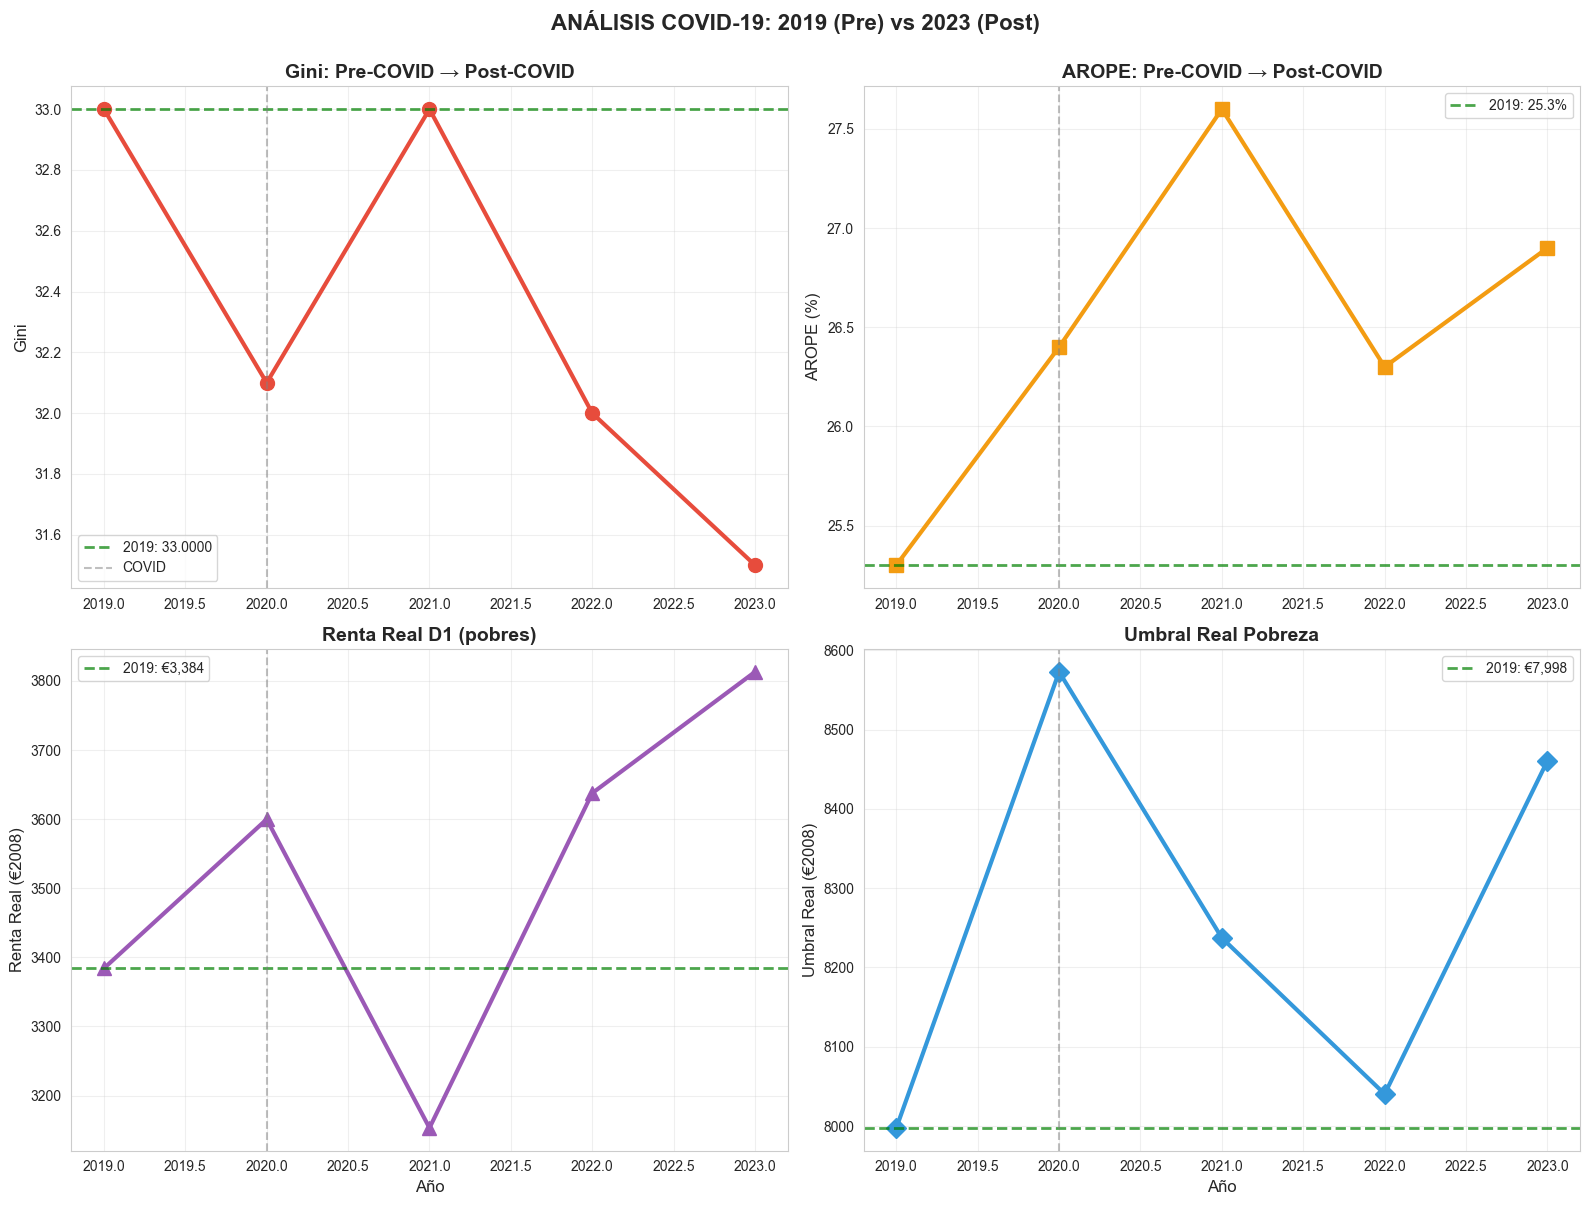

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Panel 1: Gini
ax1 = axes[0, 0]
ax1.plot(
    df_trayectoria["Año"],
    df_trayectoria["Gini"],
    marker="o",
    linewidth=3,
    markersize=10,
    color="#e74c3c",
)
ax1.axhline(
    y=gini_2019,
    color="green",
    linestyle="--",
    linewidth=2,
    alpha=0.7,
    label=f"2019: {gini_2019:.4f}",
)
ax1.axvline(
    x=2020, color="gray", linestyle="--", alpha=0.5, linewidth=1.5, label="COVID"
)
ax1.set_title("Gini: Pre-COVID → Post-COVID", fontsize=14, fontweight="bold")
ax1.set_ylabel("Gini", fontsize=12)
ax1.legend(loc="best")
ax1.grid(True, alpha=0.3)

# Panel 2: AROPE
ax2 = axes[0, 1]
ax2.plot(
    df_trayectoria["Año"],
    df_trayectoria["AROPE_%"],
    marker="s",
    linewidth=3,
    markersize=10,
    color="#f39c12",
)
ax2.axhline(
    y=arope_2019,
    color="green",
    linestyle="--",
    linewidth=2,
    alpha=0.7,
    label=f"2019: {arope_2019:.1f}%",
)
ax2.axvline(x=2020, color="gray", linestyle="--", alpha=0.5, linewidth=1.5)
ax2.set_title("AROPE: Pre-COVID → Post-COVID", fontsize=14, fontweight="bold")
ax2.set_ylabel("AROPE (%)", fontsize=12)
ax2.legend(loc="best")
ax2.grid(True, alpha=0.3)

# Panel 3: Renta D1
ax3 = axes[1, 0]
ax3.plot(
    df_trayectoria["Año"],
    df_trayectoria["Renta_D1_€2008"],
    marker="^",
    linewidth=3,
    markersize=10,
    color="#9b59b6",
)
ax3.axhline(
    y=d1_2019,
    color="green",
    linestyle="--",
    linewidth=2,
    alpha=0.7,
    label=f"2019: €{d1_2019:,.0f}",
)
ax3.axvline(x=2020, color="gray", linestyle="--", alpha=0.5, linewidth=1.5)
ax3.set_title("Renta Real D1 (pobres)", fontsize=14, fontweight="bold")
ax3.set_ylabel("Renta Real (€2008)", fontsize=12)
ax3.set_xlabel("Año", fontsize=12)
ax3.legend(loc="best")
ax3.grid(True, alpha=0.3)

# Panel 4: Umbral Real
ax4 = axes[1, 1]
ax4.plot(
    df_trayectoria["Año"],
    df_trayectoria["Umbral_€2008"],
    marker="D",
    linewidth=3,
    markersize=10,
    color="#3498db",
)
ax4.axhline(
    y=umbral_2019,
    color="green",
    linestyle="--",
    linewidth=2,
    alpha=0.7,
    label=f"2019: €{umbral_2019:,.0f}",
)
ax4.axvline(x=2020, color="gray", linestyle="--", alpha=0.5, linewidth=1.5)
ax4.set_title("Umbral Real Pobreza", fontsize=14, fontweight="bold")
ax4.set_ylabel("Umbral Real (€2008)", fontsize=12)
ax4.set_xlabel("Año", fontsize=12)
ax4.legend(loc="best")
ax4.grid(True, alpha=0.3)

plt.suptitle(
    "ANÁLISIS COVID-19: 2019 (Pre) vs 2023 (Post)",
    fontsize=16,
    fontweight="bold",
    y=1.00,
)
plt.tight_layout()
plt.show()

## 5️⃣ La Paradoja Visual: Gini Mejora, Pobres Empeoran

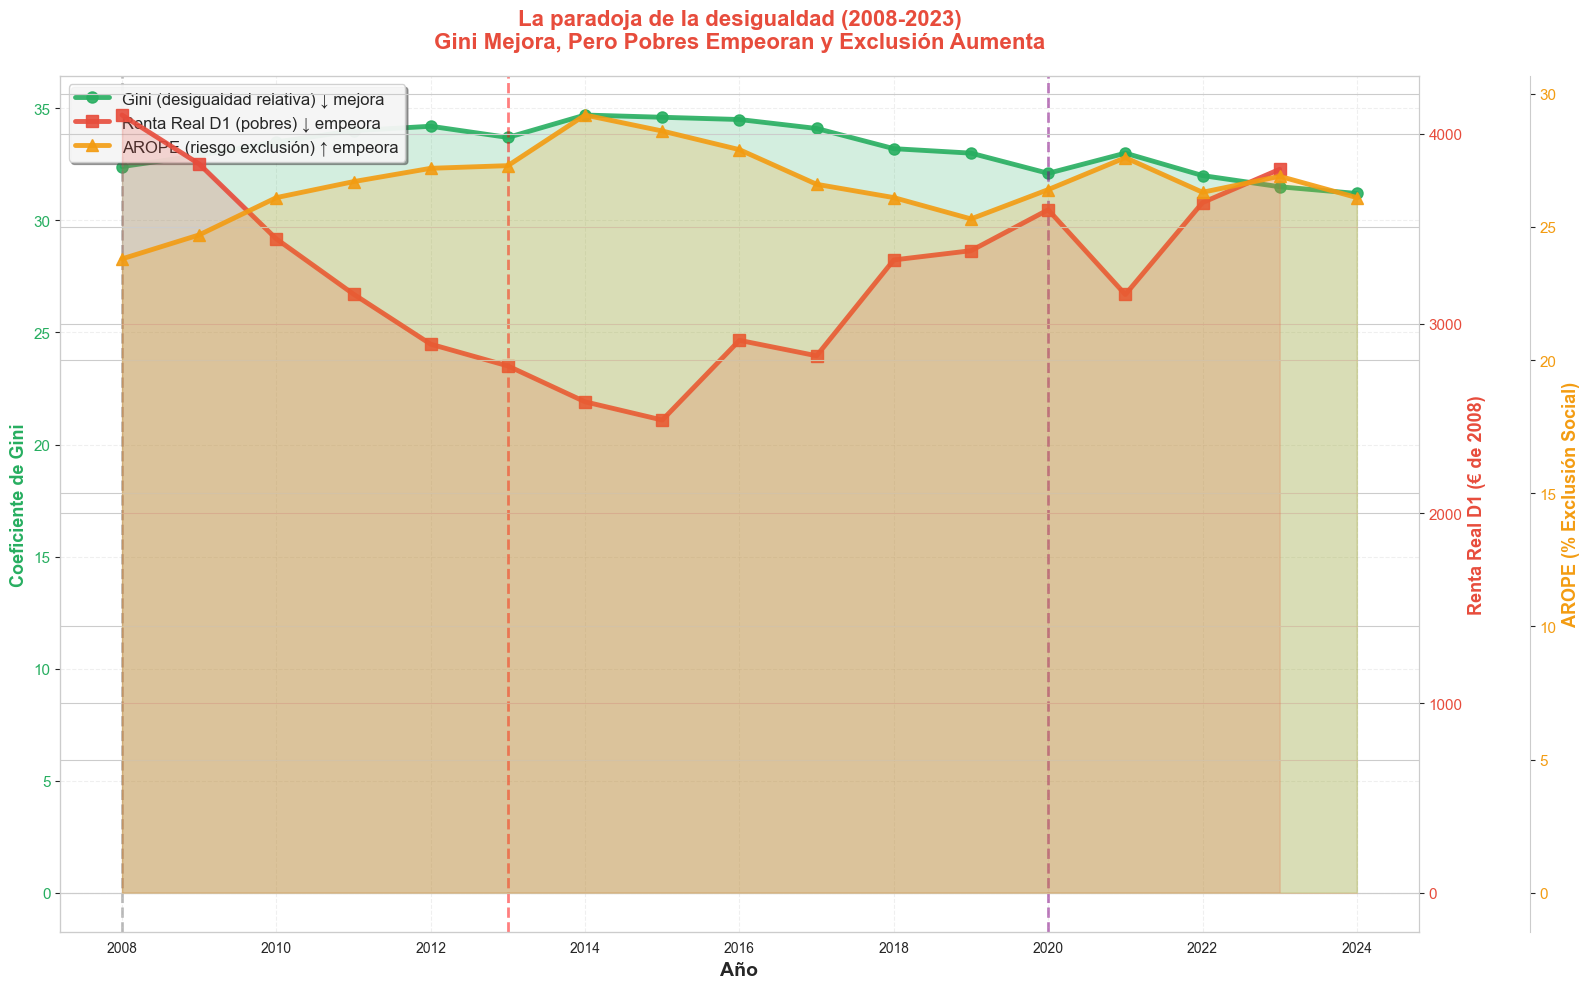


✅ Visualización de la paradoja completada


In [12]:
# Preparar datos para visualización integrada
df_gini_nacional = df_gini_s80s20.sort_values("Año")
df_d1_evolution = df_pivot_deciles["D1"].reset_index()
df_d1_evolution.columns = ["Año", "Renta_Real_D1"]

# Crear figura con 3 ejes
fig, ax1 = plt.subplots(figsize=(16, 10))

# Eje 1: Gini (izquierda)
color_gini = "#27ae60"
ax1.set_xlabel("Año", fontsize=14, fontweight="bold")
ax1.set_ylabel("Coeficiente de Gini", fontsize=13, fontweight="bold", color=color_gini)
line1 = ax1.plot(
    df_gini_nacional["Año"],
    df_gini_nacional["Gini"],
    marker="o",
    linewidth=3.5,
    markersize=8,
    color=color_gini,
    label="Gini (desigualdad relativa) ↓ mejora",
    alpha=0.9,
)
ax1.tick_params(axis="y", labelcolor=color_gini, labelsize=11)
ax1.fill_between(
    df_gini_nacional["Año"], df_gini_nacional["Gini"], alpha=0.2, color=color_gini
)
ax1.grid(True, alpha=0.3, linestyle="--")

# Eje 2: Renta Real D1 (derecha)
ax2 = ax1.twinx()
color_d1 = "#e74c3c"
ax2.set_ylabel(
    "Renta Real D1 (€ de 2008)", fontsize=13, fontweight="bold", color=color_d1
)
line2 = ax2.plot(
    df_d1_evolution["Año"],
    df_d1_evolution["Renta_Real_D1"],
    marker="s",
    linewidth=3.5,
    markersize=8,
    color=color_d1,
    label="Renta Real D1 (pobres) ↓ empeora",
    alpha=0.9,
)
ax2.tick_params(axis="y", labelcolor=color_d1, labelsize=11)
ax2.fill_between(
    df_d1_evolution["Año"], df_d1_evolution["Renta_Real_D1"], alpha=0.2, color=color_d1
)

# Eje 3: AROPE (derecha offset) - df_arope_anual viene de SQL y usa 'Anio'
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 80))
color_arope = "#f39c12"
ax3.set_ylabel(
    "AROPE (% Exclusión Social)", fontsize=13, fontweight="bold", color=color_arope
)
line3 = ax3.plot(
    df_arope_anual["Anio"],
    df_arope_anual["AROPE_%"],
    marker="^",
    linewidth=3.5,
    markersize=8,
    color=color_arope,
    label="AROPE (riesgo exclusión) ↑ empeora",
    alpha=0.9,
)
ax3.tick_params(axis="y", labelcolor=color_arope, labelsize=11)
ax3.fill_between(
    df_arope_anual["Anio"], df_arope_anual["AROPE_%"], alpha=0.2, color=color_arope
)

# Título y leyenda
plt.title(
    "La paradoja de la desigualdad (2008-2023)\nGini Mejora, Pero Pobres Empeoran y Exclusión Aumenta",
    fontsize=16,
    color="#e74c3c",
    fontweight="bold",
    pad=20,
)

# Combinar leyendas
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left", fontsize=12, framealpha=0.9, shadow=True)

# Líneas verticales
ax1.axvline(x=2008, color="gray", linestyle="--", alpha=0.5, linewidth=2)
ax1.axvline(x=2013, color="red", linestyle="--", alpha=0.5, linewidth=2)
ax1.axvline(x=2020, color="purple", linestyle="--", alpha=0.5, linewidth=2)

fig.tight_layout()
plt.show()

print("\n✅ Visualización de la paradoja completada")

## 6️⃣ Conclusiones del Análisis COVID e Inflación

In [13]:
print("\n" + "=" * 120)
print("CONCLUSIONES: COVID E INFLACIÓN DIFERENCIAL")
print("=" * 120)

print(
    """
1️⃣ INFLACIÓN DIFERENCIAL:
   • En 2022, los quintiles más pobres sufrieron inflación diferencial positiva
   • Causa: Mayor gasto en alimentos/energía con alta inflación
   • Implicación: Usar IPC general subestima empobrecimiento real de pobres

2️⃣ IMPACTO COVID (2019-2023):
   • AROPE: +{:.1f}pp - MÁS riesgo de exclusión que pre-COVID
   • Renta Real D1: {:.1f}% - Pobres PERDIERON poder adquisitivo
   • Umbral Real: {:.1f}% - Economía NO se recuperó totalmente

3️⃣ LA PARADOJA:
   • Gini MEJORA (desigualdad relativa baja)
   • PERO pobres EMPEORAN en términos absolutos
   • Y exclusión social AUMENTA
   • Explicación: Crisis empobrecedora comprime distribución, pero vulnerabilidad sube

4️⃣ VEREDICTO FINAL:
   🔴 NO hubo recuperación completa post-COVID
   🔴 Inflación 2022-2023 devoró las ganancias de 2021
   🔴 Los pobres en 2023 están PEOR que en 2019
""".format(
        cambio_arope_covid, cambio_d1_covid_pct, cambio_umbral_covid_pct
    )
)

print("=" * 120)


CONCLUSIONES: COVID E INFLACIÓN DIFERENCIAL

1️⃣ INFLACIÓN DIFERENCIAL:
   • En 2022, los quintiles más pobres sufrieron inflación diferencial positiva
   • Causa: Mayor gasto en alimentos/energía con alta inflación
   • Implicación: Usar IPC general subestima empobrecimiento real de pobres

2️⃣ IMPACTO COVID (2019-2023):
   • AROPE: +1.6pp - MÁS riesgo de exclusión que pre-COVID
   • Renta Real D1: 12.7% - Pobres PERDIERON poder adquisitivo
   • Umbral Real: 5.8% - Economía NO se recuperó totalmente

3️⃣ LA PARADOJA:
   • Gini MEJORA (desigualdad relativa baja)
   • PERO pobres EMPEORAN en términos absolutos
   • Y exclusión social AUMENTA
   • Explicación: Crisis empobrecedora comprime distribución, pero vulnerabilidad sube

4️⃣ VEREDICTO FINAL:
   🔴 NO hubo recuperación completa post-COVID
   🔴 Inflación 2022-2023 devoró las ganancias de 2021
   🔴 Los pobres en 2023 están PEOR que en 2019



## 7️⃣ Exportar Resultados

In [14]:
output_dir = project_root / "outputs"

# Exportar inflación diferencial
if not df_inflacion_diff.empty:
    df_inflacion_diff.to_parquet(
        output_dir / "inflacion_diferencial_quintil.parquet", index=False
    )
    print("✅ Inflación diferencial exportada")

# Exportar análisis COVID
tabla_covid.to_csv(output_dir / "analisis_covid_2019_2023.csv", index=False)
df_trayectoria.to_parquet(
    output_dir / "trayectoria_covid_2019_2023.parquet", index=False
)

print("\n✅ Todos los resultados exportados a:", output_dir)

✅ Inflación diferencial exportada

✅ Todos los resultados exportados a: c:\Users\mario\Desktop\Projects\desigualdad_social_etl\outputs
